In [1]:
import torch
%cd ..
# Datamodule Usage Demo
import dotenv

dotenv.load_dotenv()

/home/paulw/projects/SSLmicroUltrasound


True

## Datamodule

In [2]:
from exactvu.data.datamodule import ExactSSLDataModule

dm = ExactSSLDataModule(
    mode="self-supervised",
    prostate_region_only=True,
    needle_region_only=True,
    patch_stride_mm=(1,1),
    cohort_specifier="UVA600",
    return_metadata=True
)
dm.setup()

100%|██████████| 100/100 [00:00<00:00, 134.16it/s]


{'patient_id': 103, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS8/UVA-0103_LAL_GS8.mat', 'center': 'UVA', 'loc': 'LAL', 'grade': 'GS8', 'age': 50, 'family_history': False, 'psa': 13.3, 'pct_cancer': 90.0, 'primary_grade': 4.0, 'secondary_grade': 4.0, 'patient_specifier': 'UVA-0103', 'core_specifier': 'UVA-0103_LAL'}


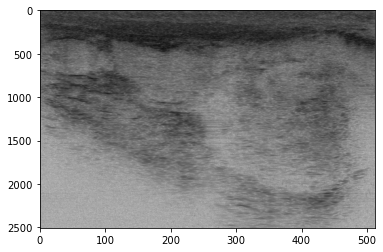

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
from exactvu.data.transforms import Transform

core_idx = 62

test_ds = dm.test_ds
_core = test_ds.cores[core_idx]
_core_data = test_ds.core_data[core_idx]
print(_core.metadata)

# download the bmode if needed
# _core.download_bmode()
_bmode = _core.bmode
_bmode = (_bmode - np.min(_bmode,keepdims=True))/(np.max(_bmode) - np.min(_bmode))
_prst_mask = _core.prostate_mask
_needle_mask = _core.needle_mask

_transform = Transform(use_augmentations=False, prob=0.0)
_patch = _transform(torch.tensor(_core_data[0][0]))

plt.grid(False)
# plt.imshow(_bmode, 'gray_r',aspect='auto', )
# plt.imshow(_prst_mask, 'gray')
plt.imshow(_needle_mask, 'gray', aspect='auto')
# plt.imshow(_patch[0,...], 'gray', aspect='auto')

## Neural model

In [186]:
from src.models.supervised.test_module import ExacTestFinetuner
from src.models.self_supervised.finetuner_module import ExactFineTuner
from src.models.self_supervised.vicreg.vicreg_module import VICReg
inv = _core.metadata["pct_cancer"]

# name = f"sl_{core_idx}_inv{inv}"
# name = f"ssl-linear_{core_idx}_inv{inv}"
name = f"ssl-semi_{core_idx}_inv{inv}"
# network_ckpt_path = "./logs/experiments/runs/fintunUVA600_ckpt/2022-08-30_10-10-58/checkpoints/epoch_011.ckpt" #26
# network_ckpt_path = "./logs/experiments/runs/fintunUVA600_prstRgn_preTrnUVA600_ckpt/2022-08-30_20-08-30/checkpoints/epoch_051.ckpt"
network_ckpt_path = "./logs/experiments/runs/fintunUVA600_prstRgn_preTrnUVA600_semi-sup_Novo/2022-08-16_10-40-47/checkpoints/epoch_011.ckpt"
model = ExacTestFinetuner(test_module=ExactFineTuner(backbone=VICReg, semi_sup=True), ckpt_path=network_ckpt_path)
model.eval()

/home/mahdigilany/offline_codes/codes/SSLmicroUltrasound/src/models/self_supervised/finetuner_module.py:64: UserWarning: You are using the finetuner model with no loadable checkpoint. The model will be randomly initialized.
  warn(
/home/mahdigilany/anaconda3/envs/ssl_env/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'test_module' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['test_module'])`.
  rank_zero_warn(
/home/mahdigilany/offline_codes/codes/SSLmicroUltrasound/src/models/self_supervised/exact_ssl_module.py:147: UserWarning: Using scheduler_interval=step might generate issues when resuming a checkpoint.
  warnings.warn(


ExacTestFinetuner(
  (backbone): VICReg(
    (val_loss_best): MinMetric()
    (backbone): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (layer2): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 128, kernel_s

In [187]:
%%time
batch_sz = 128
no_batches = int(len(_core_data)/batch_sz)

predictions = []
positions = []
for i in range(no_batches+1):
    st_idx = i*batch_sz
    end_idx = (i+1)*batch_sz if (i+1)*batch_sz<len(_core_data) else len(_core_data)

    _ = [positions.append(_core_data[i][1]) for i in range(st_idx, end_idx)]
    _data = [_transform(torch.tensor(_core_data[i][0])) for i in range(st_idx, end_idx)]
    # _patch = _transform(torch.tensor(_core_data[i][0])).unsqueeze(0)
    _patches = torch.stack(_data, dim=0)
    _repres = model.test_module.backbone(_patches)["feats"]
    _repres = _repres.view(_repres.size(0), -1)
    _pred = model.test_module.linear_layer(_repres)
    predictions.append(_pred)
predictions = torch.cat(predictions)

In [188]:
positions = []
for i in range(len(_core_data)):
    positions.append(_core_data[i][1])

## Heatmap

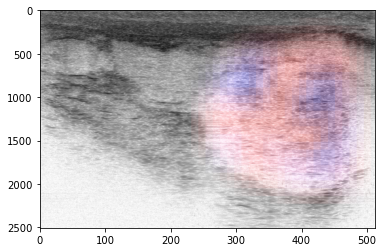

array([[[0.37194203, 0.37194203, 0.37194203],
        [0.37525406, 0.37525406, 0.37525406],
        [0.52744104, 0.52744104, 0.52744104],
        ...,
        [0.72936523, 0.72936523, 0.72936523],
        [0.61357131, 0.61357131, 0.61357131],
        [0.50185237, 0.50185237, 0.50185237]],

       [[0.3893861 , 0.3893861 , 0.3893861 ],
        [0.39625345, 0.39625345, 0.39625345],
        [0.44363191, 0.44363191, 0.44363191],
        ...,
        [0.50292275, 0.50292275, 0.50292275],
        [0.45608381, 0.45608381, 0.45608381],
        [0.39594558, 0.39594558, 0.39594558]],

       [[0.38897703, 0.38897703, 0.38897703],
        [0.4286984 , 0.4286984 , 0.4286984 ],
        [0.57454421, 0.57454421, 0.57454421],
        ...,
        [0.40231088, 0.40231088, 0.40231088],
        [0.43240868, 0.43240868, 0.43240868],
        [0.55105403, 0.55105403, 0.55105403]],

       ...,

       [[0.99449136, 0.99449136, 0.99449136],
        [0.90745664, 0.90745664, 0.90745664],
        [0.87858105, 0

In [189]:
import numpy as np
import math
from skimage.transform import resize

def plot_heatmap(bmode, prst_mask, predictions, patch_positions,  pred_transp=0.02, bmode_transp=.7):
    bmode_copy = bmode_transp*np.copy(bmode)
    # bmode_copy = np.zeros_like(bmode_copy)

    axial_mm = 28
    lateral_mm = 46
    patch_size = (5,5)

    mm_to_pixel_axial = math.floor(bmode_copy.shape[0]/axial_mm)
    mm_to_pixel_lateral = math.floor(bmode_copy.shape[1]/lateral_mm)
    transp = pred_transp

    red_patch = np.zeros((5*mm_to_pixel_axial,5*mm_to_pixel_lateral,3), dtype=float)
    red_patch[:,:,0] = transp*np.ones((5*mm_to_pixel_axial,5*mm_to_pixel_lateral), dtype=float)

    blue_patch = np.zeros((5*mm_to_pixel_axial,5*mm_to_pixel_lateral,3), dtype=float)
    blue_patch[:,:,2] = transp*np.ones((5*mm_to_pixel_axial,5*mm_to_pixel_lateral), dtype=float)

    for i in range(len(predictions)):
        pred_patch = red_patch if predictions[i]>0 else blue_patch

        u_pos = math.floor(patch_positions[i][0]*mm_to_pixel_axial)
        d_pos = math.floor(patch_positions[i][1]*mm_to_pixel_axial)
        l_pos = math.floor(patch_positions[i][2]*mm_to_pixel_lateral)
        r_pos = math.floor(patch_positions[i][3]*mm_to_pixel_lateral)


        if prst_mask[math.floor((u_pos+d_pos)/2.),math.floor((l_pos+r_pos)/2.)]:
            bmode_copy[u_pos:d_pos, l_pos:r_pos] += pred_patch

    return bmode_copy

_bmode_rgb = np.zeros((_bmode.shape[0],_bmode.shape[1],3))
_bmode_rgb[:,:,0] = _bmode
_bmode_rgb[:,:,1] = _bmode
_bmode_rgb[:,:,2] = _bmode

_prst_mask = resize(_prst_mask, (_bmode.shape[0],_bmode.shape[1]))
# plt.imshow(_prst_mask, aspect='auto')
plot_heatmap(_bmode_rgb, _prst_mask, torch.argmax(predictions,1), positions, pred_transp=0.01, bmode_transp=1.5)